### Building model with deep learning 

#### LSTM Model

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller 
from sklearn.preprocessing import MinMaxScaler 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM 
import os
import sys
import warnings
sns.set_style("darkgrid")
%matplotlib inline
sys.path.append('../src')
import warnings
warnings.filterwarnings('ignore')
from file_handler import FileHandler
from clean_data import data_preProcessing_script
from visualize_data import visualize
from cleaner import DataCleaner
File_handler=FileHandler()

In [32]:
# The load the raw sales data
train_data = pd.read_csv('../data/train_store_unlabel.csv')
#version = 'cb7918a275ad201118ee4e2a23dd0a199d7704b2'
#repo = '../'

#train_df = File_handler.dvc_get_data(data_path, version, repo)

#### Isolate the Rossmann Store Sales dataset into time series data

In [33]:
data = train_data.groupby("Date").agg({"Sales": "mean"})
data.head(10)

,Sales
Date,
2013-01-01,76.940754
2013-01-02,6008.649327
2013-01-03,5564.168610
2013-01-04,5819.339013
2013-01-05,5172.632287
2013-01-06,104.460987
2013-01-07,8307.029596
2013-01-08,7359.925561
2013-01-09,6694.852018


#### Check whether your time Series Data is Stationary


In [34]:
adfResult = adfuller(data.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')


ADF Statistic: -6.051971148790467
p-value: 1.2712249740203076e-07


In [58]:
scaler = MinMaxScaler()

try:
    scaler.fit(data.Sales.values.reshape([-1, 1]))
    scaled_array = scaler.transform(data.Sales.values.reshape(-1, 1))
    data['SalesScaled'] = scaled_array
    data.tail(10)

    logger.debug("Data scaled successfully.")

except Exception as e:
    logger.exception(f"Scaling error, {e}")

NameError: name 'logger' is not defined

In [36]:
# Check if Scaled Sales is Stationary

adfResult = adfuller(data.SalesScaled.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -6.051971148790483
p-value: 1.2712249740202097e-07


Transform the time series data into supervised learning data by creating a new y(target) column. 

In [37]:
# Create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

salesScaledDiff = difference(data.SalesScaled.values)
salesScaledDiff

0      0.684215
1     -0.051270
2      0.029434
3     -0.074597
4     -0.584607
         ...   
936    0.954427
937   -0.089492
938   -0.048192
939    0.023750
940    0.087114
Length: 941, dtype: float64

In [38]:
SIZE = len(data.SalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE = SIZE - WINDOW_SIZE * 2
EPOCHS = 200

In [39]:
DateTrain = data.index.values[0:BATCH_SIZE]
DateValid = data.index.values[BATCH_SIZE:]
XTrain = data.SalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = data.SalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (846, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (846,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [40]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([846, 1])

In [41]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

For example as illustrated here in the Sliding Window For Time Series Data section 
Scale your data in the (-1, 1) range

In [42]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)

In [43]:
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


2022-09-10 13:33:38.478911: W tensorflow/core/framework/dataset.cc:769] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-09-10 13:33:38.560881: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2022-09-10 13:33:38.625198: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


In [44]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [45]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [46]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

#### Build a LSTM Regression model to predict the next sale. 

In [47]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 8)           320       
                                                                 
 lstm_1 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 11s 11s/step - loss: 0.2012 - val_loss: 0.2148
Epoch 2/200
1/1 [==============================] - 0s 282ms/step - loss: 0.1956 - val_loss: 0.2089
Epoch 3/200
1/1 [==============================] - 0s 278ms/step - loss: 0.1902 - val_loss: 0.2033
Epoch 4/200
1/1 [==============================] - 0s 275ms/step - loss: 0.1851 - val_loss: 0.1980
Epoch 5/200
1/1 [==============================] - 0s 280ms/step - loss: 0.1802 - val_loss: 0.1928
Epoch 6/200
1/1 [==============================] - 0s 276ms/step - loss: 0.1755 - val_loss: 0.1878
Epoch 7/200
1/1 [==============================] - 0s 278ms/step - loss: 0.1710 - val_loss: 0.1829
Epoch 8/200
1/1 [==============================] - 0s 263ms/step - loss: 0.1665 - val_loss: 0.1782
Epoch 9/200
1/1 [==============================] - 0s 278ms/step - loss: 0.1622 - val_loss: 0.1736
Epoch 10/200
1/1 [==============================] - 0s 305ms/step - loss: 0.1580 - val_loss: 0.1691
Epoch 11/2

In [49]:
loss = model.evaluate(DatasetVal, verbose=1)
t_loss = model.evaluate(DatasetTrain, verbose=1)

1/1 [==============================] - 0s 242ms/step - loss: 0.0449


In [50]:
print("Training loss = %f" % (t_loss))
print("Validation loss = %f" % (loss))

Training loss = 0.044858
Validation loss = 0.043065


In [51]:
from time import gmtime, strftime

time = strftime("%Y-%m-%d", gmtime())

In [52]:
model.save(f'../models/lstm_sales_prediction_model {time}.pkl')

INFO:tensorflow:Assets written to: ../models/lstm_sales_prediction_model 2022-09-10.pkl/assets


INFO:tensorflow:Assets written to: ../models/lstm_sales_prediction_model 2022-09-10.pkl/assets


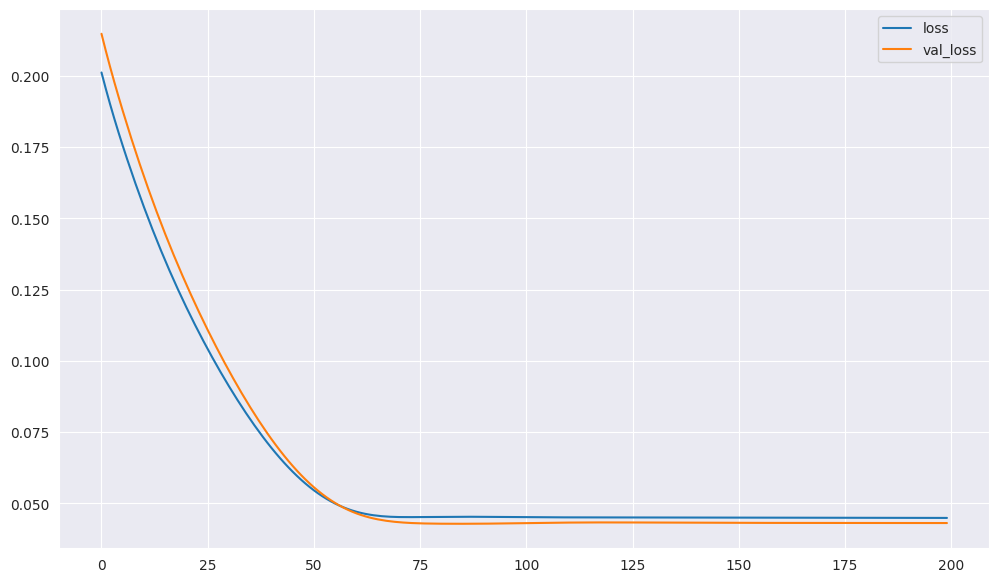

In [53]:
fig = plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [55]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True) 
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(SIZE).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Forecast = model_forecast(model, data.SalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

1/1 [==============================] - 1s 1s/step


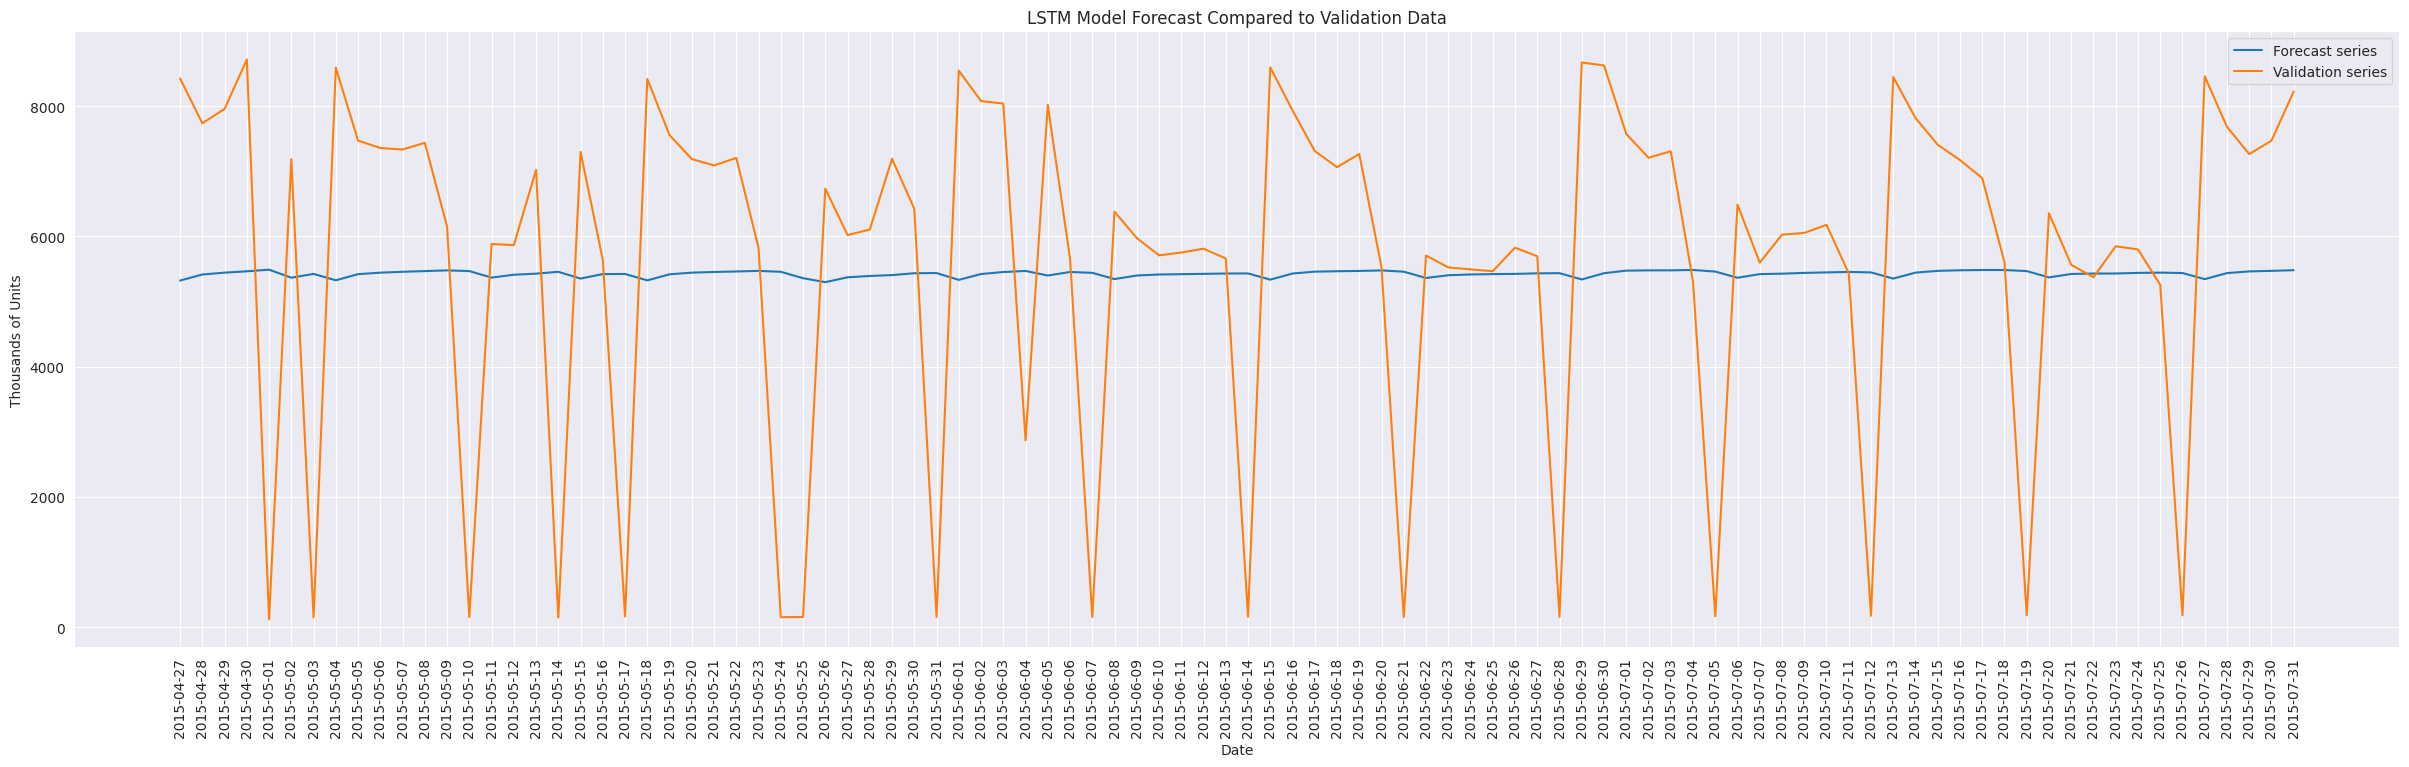

In [56]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

=============//=================